In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.evaluate_daxmodels import evaluate_different_daxmodels

from dax.help_functions.get_dax_data import get_prepared_data
#from dax.models.time_series_models.garch11_norm import get_garch_11_norm
#from dax.models.time_series_models.garch11_t import get_garch_11_t
from dax.models.baseline import get_dax_forecasts_baseline
from dax.models.QuantReg.QuantRegVol import get_QuantRegVol_forecasts, get_QuantRegVolShort_forecasts
from dax.models.ARMA_NN.arma_nn import get_arma_nn_forecasts
from dax.models.ARMA_GARCH.arma_garch import get_arma_garch_forecasts
from dax.models.combination.combined_new import combine_models


In [2]:
dax_df = get_prepared_data()

In [12]:
import numpy as np
import pandas as pd

from dax.models.baseline import get_dax_forecasts_baseline
from dax.models.QuantReg.QuantRegVol import get_QuantRegVol_forecasts, get_QuantRegVolShort_forecasts
from dax.models.ARMA_NN.arma_nn import get_arma_nn_forecasts
from dax.models.ARMA_GARCH.arma_garch import get_arma_garch_forecasts


def combine_models(daxdf=pd.DataFrame):

    daxdata0 = daxdf.copy()
    baseline = get_dax_forecasts_baseline(daxdata0)
    daxdata1 = daxdf.copy()
    quantreg = get_QuantRegVol_forecasts(daxdata1)
    daxdata2 = daxdf.copy()
    armagarch = get_arma_garch_forecasts(daxdata2)

    combined_model = quantreg.copy()
    combined_model.loc[:, 'q0.025':'q0.975'] = np.nan

    combined_model.loc[:, 'q0.025':'q0.975'].iloc[0] = np.array(
        quantreg.loc[:, 'q0.025':'q0.975'].iloc[0])
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[1] = np.array(
        armagarch.loc[:, 'q0.025':'q0.975'].iloc[1])
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[2] = np.array(
        armagarch.loc[:, 'q0.025':'q0.975'].iloc[2])
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[3] = np.array(
        quantreg.loc[:, 'q0.025':'q0.975'].iloc[3])*0.34 + np.array(armagarch.loc[:, 'q0.025':'q0.975'].iloc[3])*0.33 + np.array(baseline.loc[:, 'q0.025':'q0.975'].iloc[3])*0.33
    combined_model.loc[:, 'q0.025':'q0.975'].iloc[4] = np.array(
        quantreg.loc[:, 'q0.025':'q0.975'].iloc[4])*0.5 + np.array(armagarch.loc[:, 'q0.025':'q0.975'].iloc[4])*0.2 + np.array(baseline.loc[:, 'q0.025':'q0.975'].iloc[4])*0.3

    return combined_model

In [13]:
baseline = {
    'name': 'baseline',
    'function': get_dax_forecasts_baseline
}
QuantRegLong = {
    'name': 'Quantile Regression Long',
    'function': get_QuantRegVol_forecasts
}

QuantRegShort = {
    'name': 'Quantile Regression Short',
    'function': get_QuantRegVolShort_forecasts
}

arma_garch = {
    'name': 'ARMA GARCH',
    'function': get_arma_garch_forecasts
}

arma_nn = {
    'name': 'ARMA NN',
    'function': get_arma_nn_forecasts
}

combined = {
    'name': 'combined',
    'function': combine_models
}

models = [combined] 

In [ ]:
evaluation = evaluate_different_daxmodels(models, dax_df, last_x=20, years=False, months=False, weeks=True)

## Visualize Comparsion

In [6]:
mean_scores = {
    'baseline': np.mean(models[0]['evaluation']['score']),
    'ARMA GARCH': np.mean(models[1]['evaluation']['score']),
    'quantile regression 5 years':np.mean(models[2]['evaluation']['score']),
    'quantile regression 1 year': np.mean(models[3]['evaluation']['score']),
    'ARMA NN': np.mean(models[4]['evaluation']['score']) }
mean_scores

{'baseline': 3.185880678437114,
 'ARMA GARCH': 3.077611008618542,
 'quantile regression 5 years': 3.7831248484740945,
 'quantile regression 1 year': 3.048228822006749,
 'ARMA NN': 3.763295780989202}

In [7]:
var_scores = {
    'baseline': np.var(models[0]['evaluation']['score']),
    'ARMA GARCH': np.var(models[1]['evaluation']['score']),
    'quantile regression 5 years': np.var(models[2]['evaluation']['score']),
    'quantile regression 1 year': np.var(models[3]['evaluation']['score']),
    'ARMA NN': np.var(models[4]['evaluation']['score'])}
var_scores

{'baseline': 4.1664837169686715,
 'ARMA GARCH': 4.477145001141713,
 'quantile regression 5 years': 10.12509758524472,
 'quantile regression 1 year': 5.7427601602089275,
 'ARMA NN': 3.551529579804422}

In [15]:
horizons = ['1 day', '2 day', '5 day', '6 day', '7 day']
quantile_scores_per_model = {}

for m in range(0,len(models)):
    quantile_scores = {}
    evaluation_frame = models[m]['evaluation']
    for h in horizons: 
        day_frame = evaluation_frame.loc[evaluation_frame['horizon'] == h]
        quantile_scores.update({h: np.mean(day_frame['score'])})
    
    quantile_scores_per_model.update({models[m]['name']: quantile_scores})

quantile_scores_per_model
    

{'combined': {'1 day': 1.709072313855457,
  '2 day': 2.4906248959317585,
  '5 day': 2.9073636523983017,
  '6 day': 3.5447953451388305,
  '7 day': 4.580719206001105}}

In [16]:
horizons = ['1 day', '2 day', '5 day', '6 day', '7 day']
quantile_scores_per_model = {}

for m in range(0, len(models)):
    quantile_scores = {}
    evaluation_frame = models[m]['evaluation']
    for h in horizons:
        day_frame = evaluation_frame.loc[evaluation_frame['horizon'] == h]
        quantile_scores.update({h: np.var(day_frame['score'])})

    quantile_scores_per_model.update({models[m]['name']: quantile_scores})

quantile_scores_per_model

{'combined': {'1 day': 0.8866879907598716,
  '2 day': 2.3527843853634085,
  '5 day': 2.493931191173306,
  '6 day': 4.807231417048469,
  '7 day': 7.169044612272261}}

In [10]:
score_summary = pd.DataFrame()
horizons = ['1 Day', '2 Day', '3 Day', '60 hour', '64 hour', '68 hour']

var_score = {}  # model, horizon, mean_score
for h in horizons:
    var_scores = []
    for m in models:
        m_score = np.var(m['evaluation']['score']
                          [m['evaluation']['horizon'] == h])
        var_scores.append(m_score)
    score_summary[h] = var_scores

score_summary

,1 Day,2 Day,3 Day,60 hour,64 hour,68 hour
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Dictionary to store means for each key
means_dict = {}

# Calculate mean for each key
for key, inner_dict in quantile_scores_per_model.items():
    # Extract values from the inner dictionary and calculate mean
    day_values = list(inner_dict.values())
    mean_value = sum(day_values) / len(day_values)

    # Store the mean in the means_dict
    means_dict[key] = mean_value

# Print the results
for key, mean_value in means_dict.items():
    print(f"Mean for {key}: {mean_value}")

Mean for baseline: 3.1896437652016574
Mean for ARMA GARCH: 3.0496577126325106
Mean for Quantile Regression Long: 3.082757084528189
Mean for Quantile Regression Short: 3.7784377837044403
Mean for ARMA NN: 4.41095856959729


In [8]:
# Create a dictionary to store variances
variances_dict = {}

# Calculate variance for each key
for key, inner_dict in quantile_scores_per_model.items():
    # Extract values from the inner dictionary
    day_values = list(inner_dict.values())

    # Calculate the mean
    mean_value = sum(day_values) / len(day_values)

    # Calculate the squared differences from the mean
    squared_diff = [(value - mean_value)**2 for value in day_values]

    # Calculate the variance
    variance_value = sum(squared_diff) / len(day_values)

    # Store the variance in the variances_dict
    variances_dict[key] = variance_value

# Print the results
for key, variance_value in variances_dict.items():
    print(f"Variance for {key}: {variance_value}")

NameError: name 'quantile_scores_per_model' is not defined

In [11]:
# create table only containing different scores of different models

horizons = ['1 day', '2 day', '5 day', '6 day', '7 day']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

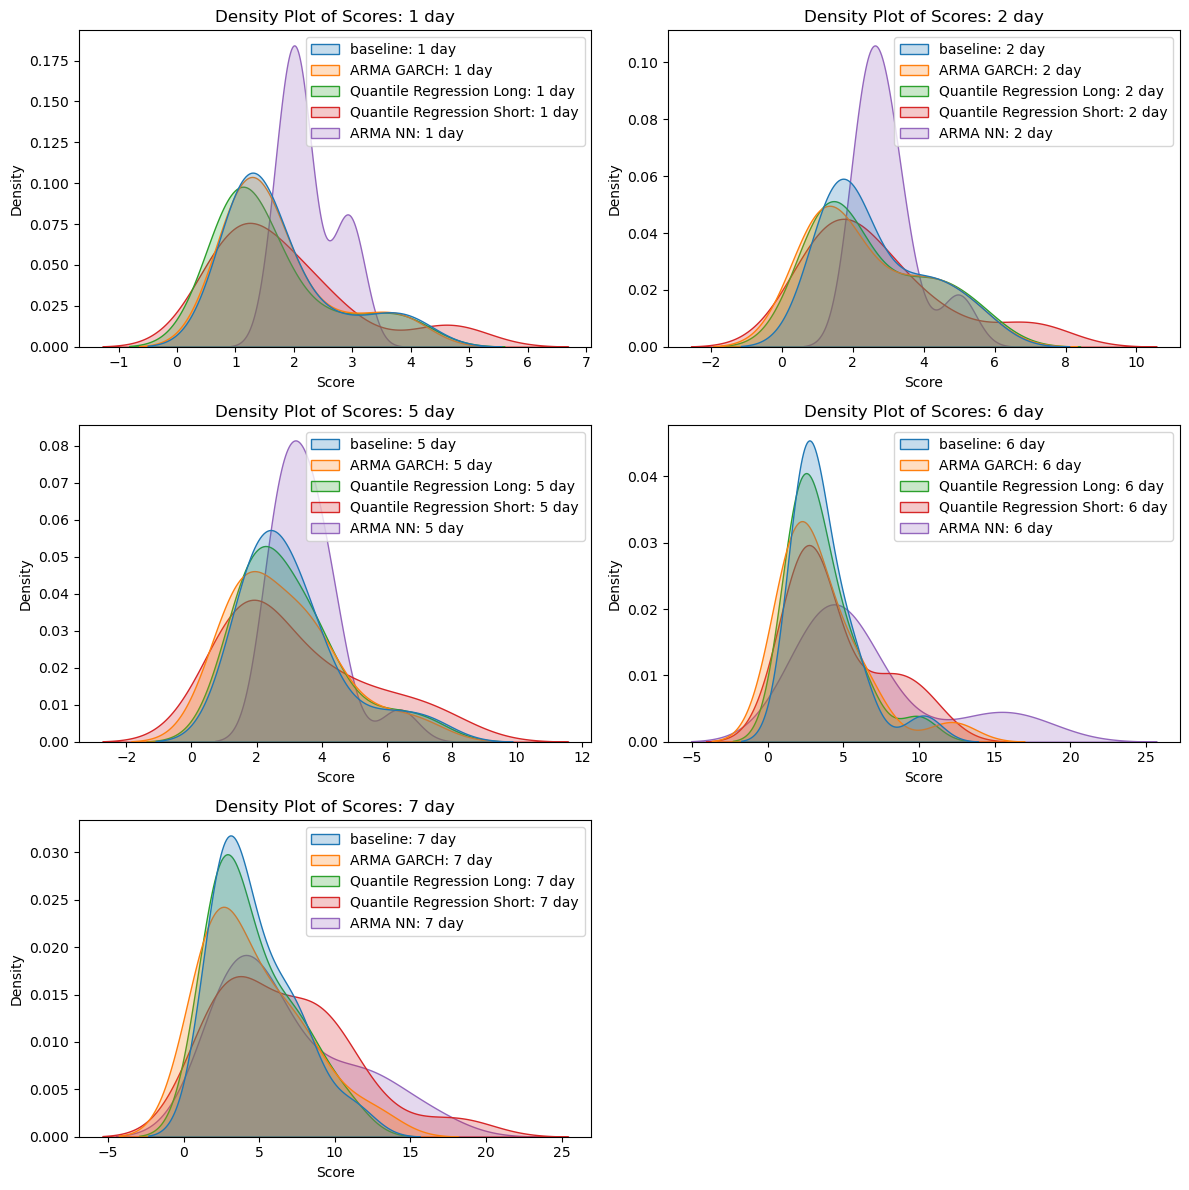

In [18]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through each horizon
for i, h in enumerate(horizons):
    # Select columns related to the current horizon
    relevant_cols = [f'{m["name"]}: {h}' for m in models]

    # Filter the relevant data for the current horizon
    data_subset = score_df.loc[:, relevant_cols]

    # Create a KDE plot for the current horizon
    sns.kdeplot(data=data_subset, fill=True, ax=axes[i])

    # Set labels and title for each subplot
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot of Scores: {h}')

fig.delaxes(ax = axes[5])

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plots
plt.show()

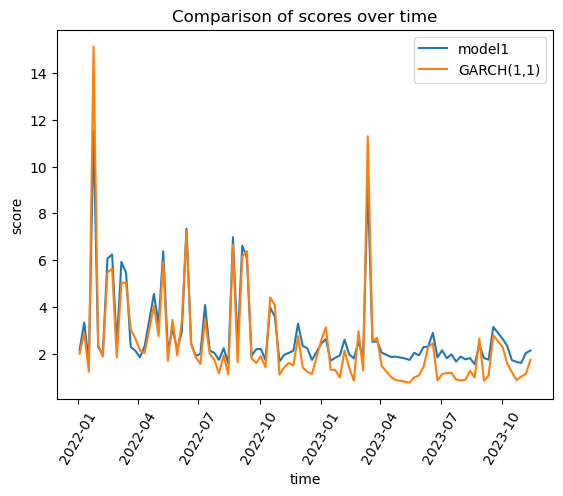

In [9]:
# Plot values from two columns over time
score_df_1d_no_na = score_df[score_df['model1: 5 day'].notna()]
score_df_garch_no_na = score_df[score_df['GARCH(1,1) model: 5 day'].notna()]

plt.plot(score_df_1d_no_na.index,
         score_df_1d_no_na['model1: 5 day'], label='model1')
plt.plot(score_df_garch_no_na.index, score_df_garch_no_na['GARCH(1,1) model: 5 day'], label='GARCH(1,1)')

# Adding labels and title
plt.xlabel('time')
plt.xticks(rotation=60)
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()

### Interpretation
GARCH(1,1) better than baseline (model1). 